# Scalable GP Classification in 1D (w/ KISS-GP)

This example shows how to use grid interpolation based variational classification with an `AbstractVariationalGP` using a `GridInterpolationVariationalStrategy` module. This classification module is designed for when the inputs of the function you're modeling are one-dimensional.

The use of inducing points allows for scaling up the training data by making computational complexity linear instead of cubic.

In this example, we’re modeling a function that is periodically labeled cycling every 1/8 (think of a square wave with period 1/4)

This notebook doesn't use cuda, in general we recommend GPU use if possible and most of our notebooks utilize cuda as well.

Kernel interpolation for scalable structured Gaussian processes (KISS-GP) was introduced in this paper:
http://proceedings.mlr.press/v37/wilson15.pdf

KISS-GP with SVI for classification was introduced in this paper:
https://papers.nips.cc/paper/6426-stochastic-variational-deep-kernel-learning.pdf

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from math import exp

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
train_x = torch.linspace(0, 1, 26)
train_y = torch.sign(torch.cos(train_x * (2 * math.pi))).add(1).div(2)

In [3]:
from gpytorch.models import AbstractVariationalGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import GridInterpolationVariationalStrategy


class GPClassificationModel(AbstractVariationalGP):
    def __init__(self, grid_size=128, grid_bounds=[(0, 1)]):
        variational_distribution = CholeskyVariationalDistribution(grid_size)
        variational_strategy = GridInterpolationVariationalStrategy(self, grid_size, grid_bounds, variational_distribution)
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


model = GPClassificationModel()
likelihood = gpytorch.likelihoods.BernoulliLikelihood()

In [4]:
from gpytorch.mlls.variational_elbo import VariationalELBO

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# "Loss" for GPs - the marginal log likelihood
# n_data refers to the amount of training data
mll = VariationalELBO(likelihood, model, num_data=train_y.numel())

def train():
    num_iter = 100
    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, num_iter, loss.item()))
        optimizer.step()
        
# Get clock time
%time train()

Iter 1/100 - Loss: 0.070
Iter 2/100 - Loss: 14.834
Iter 3/100 - Loss: 0.977
Iter 4/100 - Loss: 3.547
Iter 5/100 - Loss: 8.699
Iter 6/100 - Loss: 6.352
Iter 7/100 - Loss: 1.795
Iter 8/100 - Loss: 0.188
Iter 9/100 - Loss: 2.075
Iter 10/100 - Loss: 4.160
Iter 11/100 - Loss: 3.899
Iter 12/100 - Loss: 1.941
Iter 13/100 - Loss: 0.344
Iter 14/100 - Loss: 0.360
Iter 15/100 - Loss: 1.501
Iter 16/100 - Loss: 2.298
Iter 17/100 - Loss: 1.944
Iter 18/100 - Loss: 0.904
Iter 19/100 - Loss: 0.177
Iter 20/100 - Loss: 0.297
Iter 21/100 - Loss: 0.916
Iter 22/100 - Loss: 1.281
Iter 23/100 - Loss: 1.024
Iter 24/100 - Loss: 0.451
Iter 25/100 - Loss: 0.111
Iter 26/100 - Loss: 0.246
Iter 27/100 - Loss: 0.593
Iter 28/100 - Loss: 0.733
Iter 29/100 - Loss: 0.526
Iter 30/100 - Loss: 0.206
Iter 31/100 - Loss: 0.087
Iter 32/100 - Loss: 0.225
Iter 33/100 - Loss: 0.408
Iter 34/100 - Loss: 0.413
Iter 35/100 - Loss: 0.245
Iter 36/100 - Loss: 0.091
Iter 37/100 - Loss: 0.096
Iter 38/100 - Loss: 0.210
Iter 39/100 - Loss: 

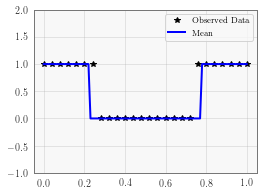

In [5]:
# Set model and likelihood into eval mode
model.eval()
likelihood.eval()

# Initialize axes
f, ax = plt.subplots(1, 1, figsize=(4, 3))

with torch.no_grad():
    test_x = torch.linspace(0, 1, 101)
    predictions = likelihood(model(test_x))

ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
pred_labels = predictions.mean.ge(0.5).float()
ax.plot(test_x.data.numpy(), pred_labels.numpy(), 'b')
ax.set_ylim([-1, 2])
ax.legend(['Observed Data', 'Mean', 'Confidence'])